# Giving Claude a Crop Tool for Better Image Analysis

When Claude analyzes images, it sees the entire image at once. For detailed tasks—like reading small text, comparing similar values in a chart, or examining fine details—this can be limiting.

**The solution:** Give Claude a tool that lets it "zoom in" by cropping regions of interest.

This notebook shows how to build a simple crop tool and demonstrates when it's useful.

## When is a Crop Tool Useful?

- **Charts and graphs**: Comparing bars/lines that are close in value, reading axis labels
- **Documents**: Reading small text, examining signatures or stamps
- **Technical diagrams**: Following wires/connections, reading component labels
- **Dense images**: Any image where details are small relative to the whole

## Setup

In [1]:
%pip install -q anthropic pillow datasets

Note: you may need to restart the kernel to use updated packages.


In [28]:
import base64
from io import BytesIO

from anthropic import Anthropic
from datasets import load_dataset
from IPython.display import Image, display
from PIL import Image as PILImage

client = Anthropic()
MODEL = "claude-opus-4-5-20251101"

## Load an Example Chart

We'll use a chart from the FigureQA dataset to demonstrate.

Question: Is Cyan the minimum?
Answer: Yes.


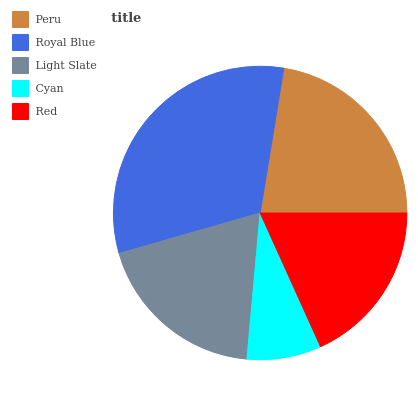

In [3]:
# Load a small subset of FigureQA
dataset = load_dataset("vikhyatk/figureqa", split="train[:10]")


# Helper to convert dataset images to PIL
def get_pil_image(img) -> PILImage.Image:
    if isinstance(img, PILImage.Image):
        return img
    if isinstance(img, dict) and "bytes" in img:
        return PILImage.open(BytesIO(img["bytes"]))
    raise ValueError(f"Cannot convert {type(img)}")


# Get an example chart
example = dataset[3]
chart_image = get_pil_image(example["image"])
question = example["qa"][0]["question"]
answer = example["qa"][0]["answer"]

print(f"Question: {question}")
print(f"Answer: {answer}")
display(chart_image)

## Define the Crop Tool

The crop tool uses **normalized coordinates** (0-1) so Claude doesn't need to know the image dimensions:
- `(0, 0)` = top-left corner
- `(1, 1)` = bottom-right corner
- `(0.5, 0.5)` = center

In [4]:
def pil_to_base64(image: PILImage.Image) -> str:
    """Convert PIL Image to base64 string."""
    if image.mode in ("RGBA", "P"):
        image = image.convert("RGB")
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.standard_b64encode(buffer.getvalue()).decode("utf-8")


# Tool definition for the Anthropic API
CROP_TOOL = {
    "name": "crop_image",
    "description": "Crop an image by specifying a bounding box.",
    "input_schema": {
        "type": "object",
        "properties": {
            "x1": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Left edge of bounding box as normalized 0-1 value, where 0.5 is the horizontal center of the image",
            },
            "y1": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Top edge of bounding box as normalized 0-1 value, where 0.5 is the vertical center of the image",
            },
            "x2": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Right edge of bounding box as normalized 0-1 value, where 0.5 is the horizontal center of the image",
            },
            "y2": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Bottom edge of bounding box as normalized 0-1 value, where 0.5 is the vertical center of the image",
            },
        },
        "required": ["x1", "y1", "x2", "y2"],
    },
}


def handle_crop(image: PILImage.Image, x1: float, y1: float, x2: float, y2: float) -> list:
    """Execute the crop and return the result for Claude."""
    # Validate
    if not all(0 <= c <= 1 for c in [x1, y1, x2, y2]):
        return [{"type": "text", "text": "Error: Coordinates must be between 0 and 1"}]
    if x1 >= x2 or y1 >= y2:
        return [{"type": "text", "text": "Error: Invalid bounding box (need x1 < x2 and y1 < y2)"}]

    # Crop
    w, h = image.size
    cropped = image.crop((int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)))

    return [
        {
            "type": "text",
            "text": f"Cropped to ({x1:.2f},{y1:.2f})-({x2:.2f},{y2:.2f}): {cropped.width}x{cropped.height}px",
        },
        {
            "type": "image",
            "source": {"type": "base64", "media_type": "image/png", "data": pil_to_base64(cropped)},
        },
    ]

Let's test the crop tool manually:

Cropped to (0.00,0.00)-(0.40,0.35): 167x140px


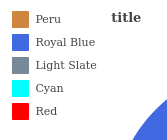

In [24]:
# Crop the legend area (top-right of most charts)
result = handle_crop(chart_image, x1=0.0, y1=0.0, x2=0.4, y2=0.35)
print(result[0]["text"])
display(Image(data=base64.b64decode(result[1]["source"]["data"])))

## The Agentic Loop

Now we connect everything: send the image to Claude with the crop tool available, and handle tool calls in a loop until Claude provides a final answer.

In [32]:
def ask_with_crop_tool(image: PILImage.Image, question: str) -> str:
    """Ask Claude a question about an image, with the crop tool available."""

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"Answer the following question about this image.\n\nThe question is: {question}\n\n",
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": pil_to_base64(image),
                    },
                },
                {
                    "type": "text",
                    "text": "\n\nUse your crop_image tool to examine specific regions including legends and axes.",
                },
            ],
        }
    ]

    while True:
        response = client.messages.create(
            model=MODEL, max_tokens=1024, tools=[CROP_TOOL], messages=messages
        )

        # Print assistant's response
        for block in response.content:
            if hasattr(block, "text"):
                print(f"[Assistant] {block.text}")
            elif block.type == "tool_use":
                print(f"[Tool] crop_image({block.input})")

        # If Claude is done, return
        if response.stop_reason != "tool_use":
            return

        # Execute tool calls and continue
        messages.append({"role": "assistant", "content": response.content})

        tool_results = []
        for block in response.content:
            if block.type == "tool_use":
                result = handle_crop(image, **block.input)
                # Display the cropped image
                for item in result:
                    if item.get("type") == "image":
                        display(Image(data=base64.b64decode(item["source"]["data"])))
                tool_results.append(
                    {"type": "tool_result", "tool_use_id": block.id, "content": result}
                )

        messages.append({"role": "user", "content": tool_results})

## Demo: Chart Analysis

Let's ask Claude to analyze our chart. Watch how it uses the crop tool to examine specific regions.

Question: Is Cyan the minimum?



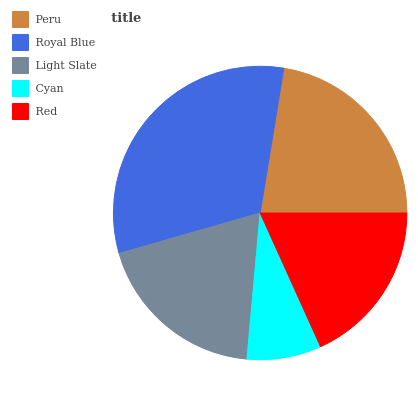


Claude's analysis:

[Assistant] I'll help you answer whether Cyan is the minimum in this pie chart. Let me examine the image more closely.
[Tool] crop_image({'x1': 0.0, 'y1': 0.0, 'x2': 0.3, 'y2': 0.3})
[Tool] crop_image({'x1': 0.3, 'y1': 0.3, 'x2': 0.7, 'y2': 0.7})


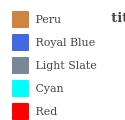

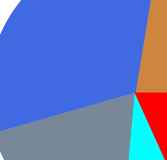

[Assistant] Based on my examination of the pie chart, I can see the relative sizes of each segment:

1. **Royal Blue** - appears to be the largest segment, taking up roughly 35-40% of the pie
2. **Peru** (brown/orange) - appears to be the second largest, roughly 25-30%
3. **Red** - appears to be third, roughly 20%
4. **Light Slate** (gray) - appears to be fourth, roughly 15%
5. **Cyan** - appears to be the smallest segment, roughly 5-10%

**Answer: Yes, Cyan is the minimum.** 

Cyan has the smallest slice in the pie chart, making it the minimum value among all five categories shown.

Ground truth: Yes.


In [33]:
print(f"Question: {question}\n")
display(chart_image)

print("\nClaude's analysis:\n")
ask_with_crop_tool(chart_image, question)

print(f"\nGround truth: {answer}")

## Try Another Example

Question: Is Forest Green greater than Medium Orchid?



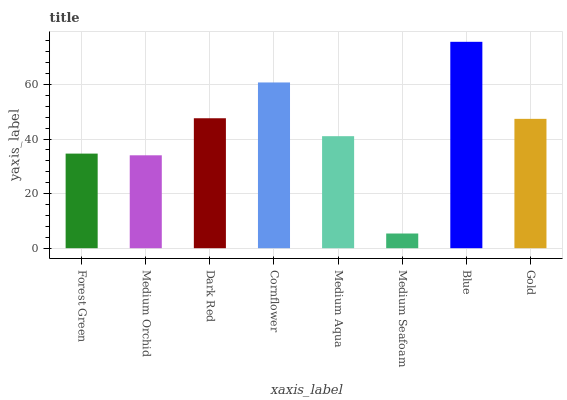


Claude's analysis:

[Assistant] I'll help you answer whether Forest Green is greater than Medium Orchid. Let me first examine the image to identify these colors and their values.
[Tool] crop_image({'x1': 0, 'y1': 0, 'x2': 0.3, 'y2': 1})
[Tool] crop_image({'x1': 0, 'y1': 0.85, 'x2': 1, 'y2': 1})


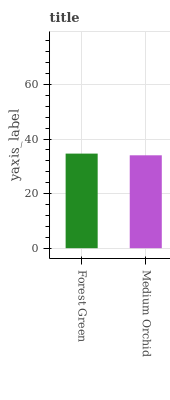

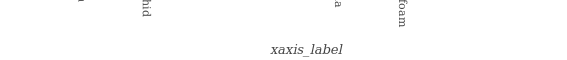

[Assistant] Based on the chart, I can see:

- **Forest Green** (the first bar on the left, dark green color) has a value of approximately 35
- **Medium Orchid** (the second bar, purple/orchid color) has a value of approximately 34

**Answer: Yes, Forest Green is greater than Medium Orchid.**

Forest Green has a slightly higher value (around 35) compared to Medium Orchid (around 34), though the difference is quite small.

Ground truth: Yes.


In [45]:
# Try a different chart and question
example2 = dataset[6]
chart2 = get_pil_image(example2["image"])
q2 = example2["qa"][2]["question"]
a2 = example2["qa"][2]["answer"]

print(f"Question: {q2}\n")
display(chart2)

print("\nClaude's analysis:\n")
ask_with_crop_tool(chart2, q2)

print(f"\nGround truth: {a2}")

## Summary

The crop tool pattern is simple but powerful:

1. **Define a tool** that takes normalized bounding box coordinates
2. **Return the cropped image** as base64 in the tool result
3. **Let Claude decide** when and where to crop

This works because Claude can see the full image first, identify regions that need closer inspection, and iteratively zoom in.

## Alternative: Using the Claude Agent SDK

The [Claude Agent SDK](https://github.com/anthropics/claude-agent-sdk-python) provides a cleaner way to define tools using Python decorators and handles the agentic loop automatically.

In [11]:
%pip install -q claude-agent-sdk

Note: you may need to restart the kernel to use updated packages.


In [12]:
from pathlib import Path

from claude_agent_sdk import ClaudeAgentOptions, ClaudeSDKClient, create_sdk_mcp_server, tool

# Working directory for the tool to resolve relative paths
tool_working_dir: str | None = None


@tool(
    "crop_image",
    "Crop an image by specifying a bounding box. Loads the image from a relative filepath.",
    {
        "type": "object",
        "properties": {
            "image_path": {
                "type": "string",
                "description": "Relative path to the image file (e.g., 'chart.png')",
            },
            "x1": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Left edge of bounding box as normalized 0-1 value, where 0.5 is the horizontal center of the image",
            },
            "y1": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Top edge of bounding box as normalized 0-1 value, where 0.5 is the vertical center of the image",
            },
            "x2": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Right edge of bounding box as normalized 0-1 value, where 0.5 is the horizontal center of the image",
            },
            "y2": {
                "type": "number",
                "minimum": 0,
                "maximum": 1,
                "description": "Bottom edge of bounding box as normalized 0-1 value, where 0.5 is the vertical center of the image",
            },
        },
        "required": ["image_path", "x1", "y1", "x2", "y2"],
    },
)
async def crop_image_tool(args: dict):
    """Crop tool that loads images from a filepath."""
    global tool_working_dir

    image_path = args["image_path"]
    x1, y1, x2, y2 = args["x1"], args["y1"], args["x2"], args["y2"]

    if not all(0 <= c <= 1 for c in [x1, y1, x2, y2]):
        return {"content": [{"type": "text", "text": "Error: Coordinates must be between 0 and 1"}]}
    if x1 >= x2 or y1 >= y2:
        return {
            "content": [
                {"type": "text", "text": "Error: Invalid bounding box (need x1 < x2 and y1 < y2)"}
            ]
        }

    # Resolve relative paths against working directory
    path = Path(image_path)
    if not path.is_absolute() and tool_working_dir:
        path = Path(tool_working_dir) / image_path

    # Load image from path
    try:
        image = PILImage.open(path)
    except FileNotFoundError:
        return {"content": [{"type": "text", "text": f"Error: Image not found at {path}"}]}
    except Exception as e:
        return {"content": [{"type": "text", "text": f"Error loading image: {e}"}]}

    w, h = image.size
    cropped = image.crop((int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)))

    # Return using MCP image format (data + mimeType, not Anthropic API source format)
    return {
        "content": [
            {
                "type": "text",
                "text": f"Cropped {image_path} to ({x1:.2f},{y1:.2f})-({x2:.2f},{y2:.2f}): {cropped.width}x{cropped.height}px",
            },
            {"type": "image", "data": pil_to_base64(cropped), "mimeType": "image/png"},
        ]
    }


# Create an MCP server with our tool
crop_server = create_sdk_mcp_server(
    name="crop-tools",
    version="1.0.0",
    tools=[crop_image_tool],
)

Question: Is Cyan the minimum?

[Assistant] I'll first read the image to understand its content, then examine specific regions if needed.
[Tool] Read({'file_path': 'chart.png'})


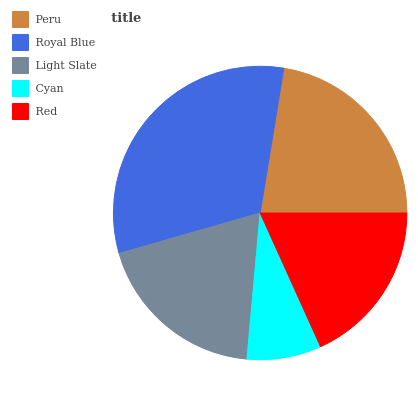

[Assistant] Looking at this pie chart, I can clearly see the different segments and their relative sizes. Let me crop the area showing the Cyan segment to examine it more closely.
[Tool] mcp__crop__crop_image({'image_path': 'chart.png', 'x1': 0.4, 'y1': 0.6, 'x2': 0.7, 'y2': 0.9})


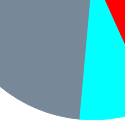

[Assistant] Now I can clearly analyze the chart. Looking at the pie chart:

**Yes, Cyan is the minimum.**

The pie chart shows 5 categories with the following relative sizes (from largest to smallest):
1. **Royal Blue** - the largest segment (takes up roughly half the pie)
2. **Peru** (tan/brown) - second largest
3. **Red** - medium-sized segment
4. **Light Slate** (gray) - smaller segment
5. **Cyan** - the smallest segment

The Cyan segment is clearly the thinnest slice of the pie, making it the minimum value among all the categories shown.


In [13]:
import tempfile


async def ask_with_agent_sdk(image: PILImage.Image, question: str):
    """Ask a question using the Claude Agent SDK with file-based image access."""
    global tool_working_dir

    with tempfile.TemporaryDirectory() as tmpdir:
        image_path = f"{tmpdir}/chart.png"
        image.save(image_path)
        tool_working_dir = tmpdir

        options = ClaudeAgentOptions(
            mcp_servers={"crop": crop_server},
            allowed_tools=["Read", "mcp__crop__crop_image"],
            cwd=tmpdir,
        )

        prompt = f"""Answer the following question about chart.png. Use your crop tool to examine specific regions of the image.

The question is: {question}"""

        async with ClaudeSDKClient(options=options) as client:
            await client.query(prompt)

            async for message in client.receive_response():
                msg_type = type(message).__name__
                if msg_type in ("SystemMessage", "ResultMessage"):
                    continue

                if hasattr(message, "content") and isinstance(message.content, list):
                    for block in message.content:
                        if hasattr(block, "text"):
                            print(f"[Assistant] {block.text}")
                        elif hasattr(block, "name"):
                            print(f"[Tool] {block.name}({block.input})")
                        elif hasattr(block, "content") and isinstance(block.content, list):
                            for item in block.content:
                                if isinstance(item, dict) and item.get("type") == "image":
                                    img_data = item.get("data") or item.get("source", {}).get(
                                        "data"
                                    )
                                    if img_data:
                                        display(Image(data=base64.b64decode(img_data)))


# Run the same question with the Agent SDK
print(f"Question: {question}\n")
await ask_with_agent_sdk(chart_image, question)